# Notebook exploring MNE-Python's ICA Capability
___

- [sklearn](https://scikit-learn.org/stable/modules/decomposition.html#independent-component-analysis-ica)
- [MNE-Py tut](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#repairing-artifacts-with-ica)
- [MNE-Python API Reference](https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA)

## Imports

In [ ]:
import pandas as pd
import numpy as np
import mne
from mne.preprocessing import ICA

import tools
import matplotlib.pyplot as plt
%matplotlib qt


In [26]:
with open("../config.json", 'rb') as f:
    config = pd.read_json(f, typ='series')

# iEEG_filename = "HUP212_CCEP"
# start_time_usec = 19091 * 1e6
# stop_time_usec = 19291 * 1e6

iEEG_filename = "HUP172_phaseII"
start_time_usec = 402580 * 1e6
stop_time_usec = 402600 * 1e6


In [27]:
data, fs = tools.get_iEEG_data(config.usr, config.pwd, iEEG_filename, start_time_usec, stop_time_usec)


In [28]:
# clean channel labels
clean_channels = tools.clean_labels(data.columns)
# find and return a boolean mask for non ieeg channels
non_ieeg_channels = tools.find_non_ieeg(clean_channels)

data.columns = clean_channels
data = data.iloc[:, ~non_ieeg_channels]


## MNE Format

In [29]:
mneInfo = mne.create_info(data.columns.to_list(), fs, 'eeg')
raw = mne.io.RawArray(data.T, mneInfo)

Creating RawArray with float64 data, n_channels=134, n_times=10240
    Range : 0 ... 10239 =      0.000 ...    19.998 secs
Ready.


### Intuitive plotting

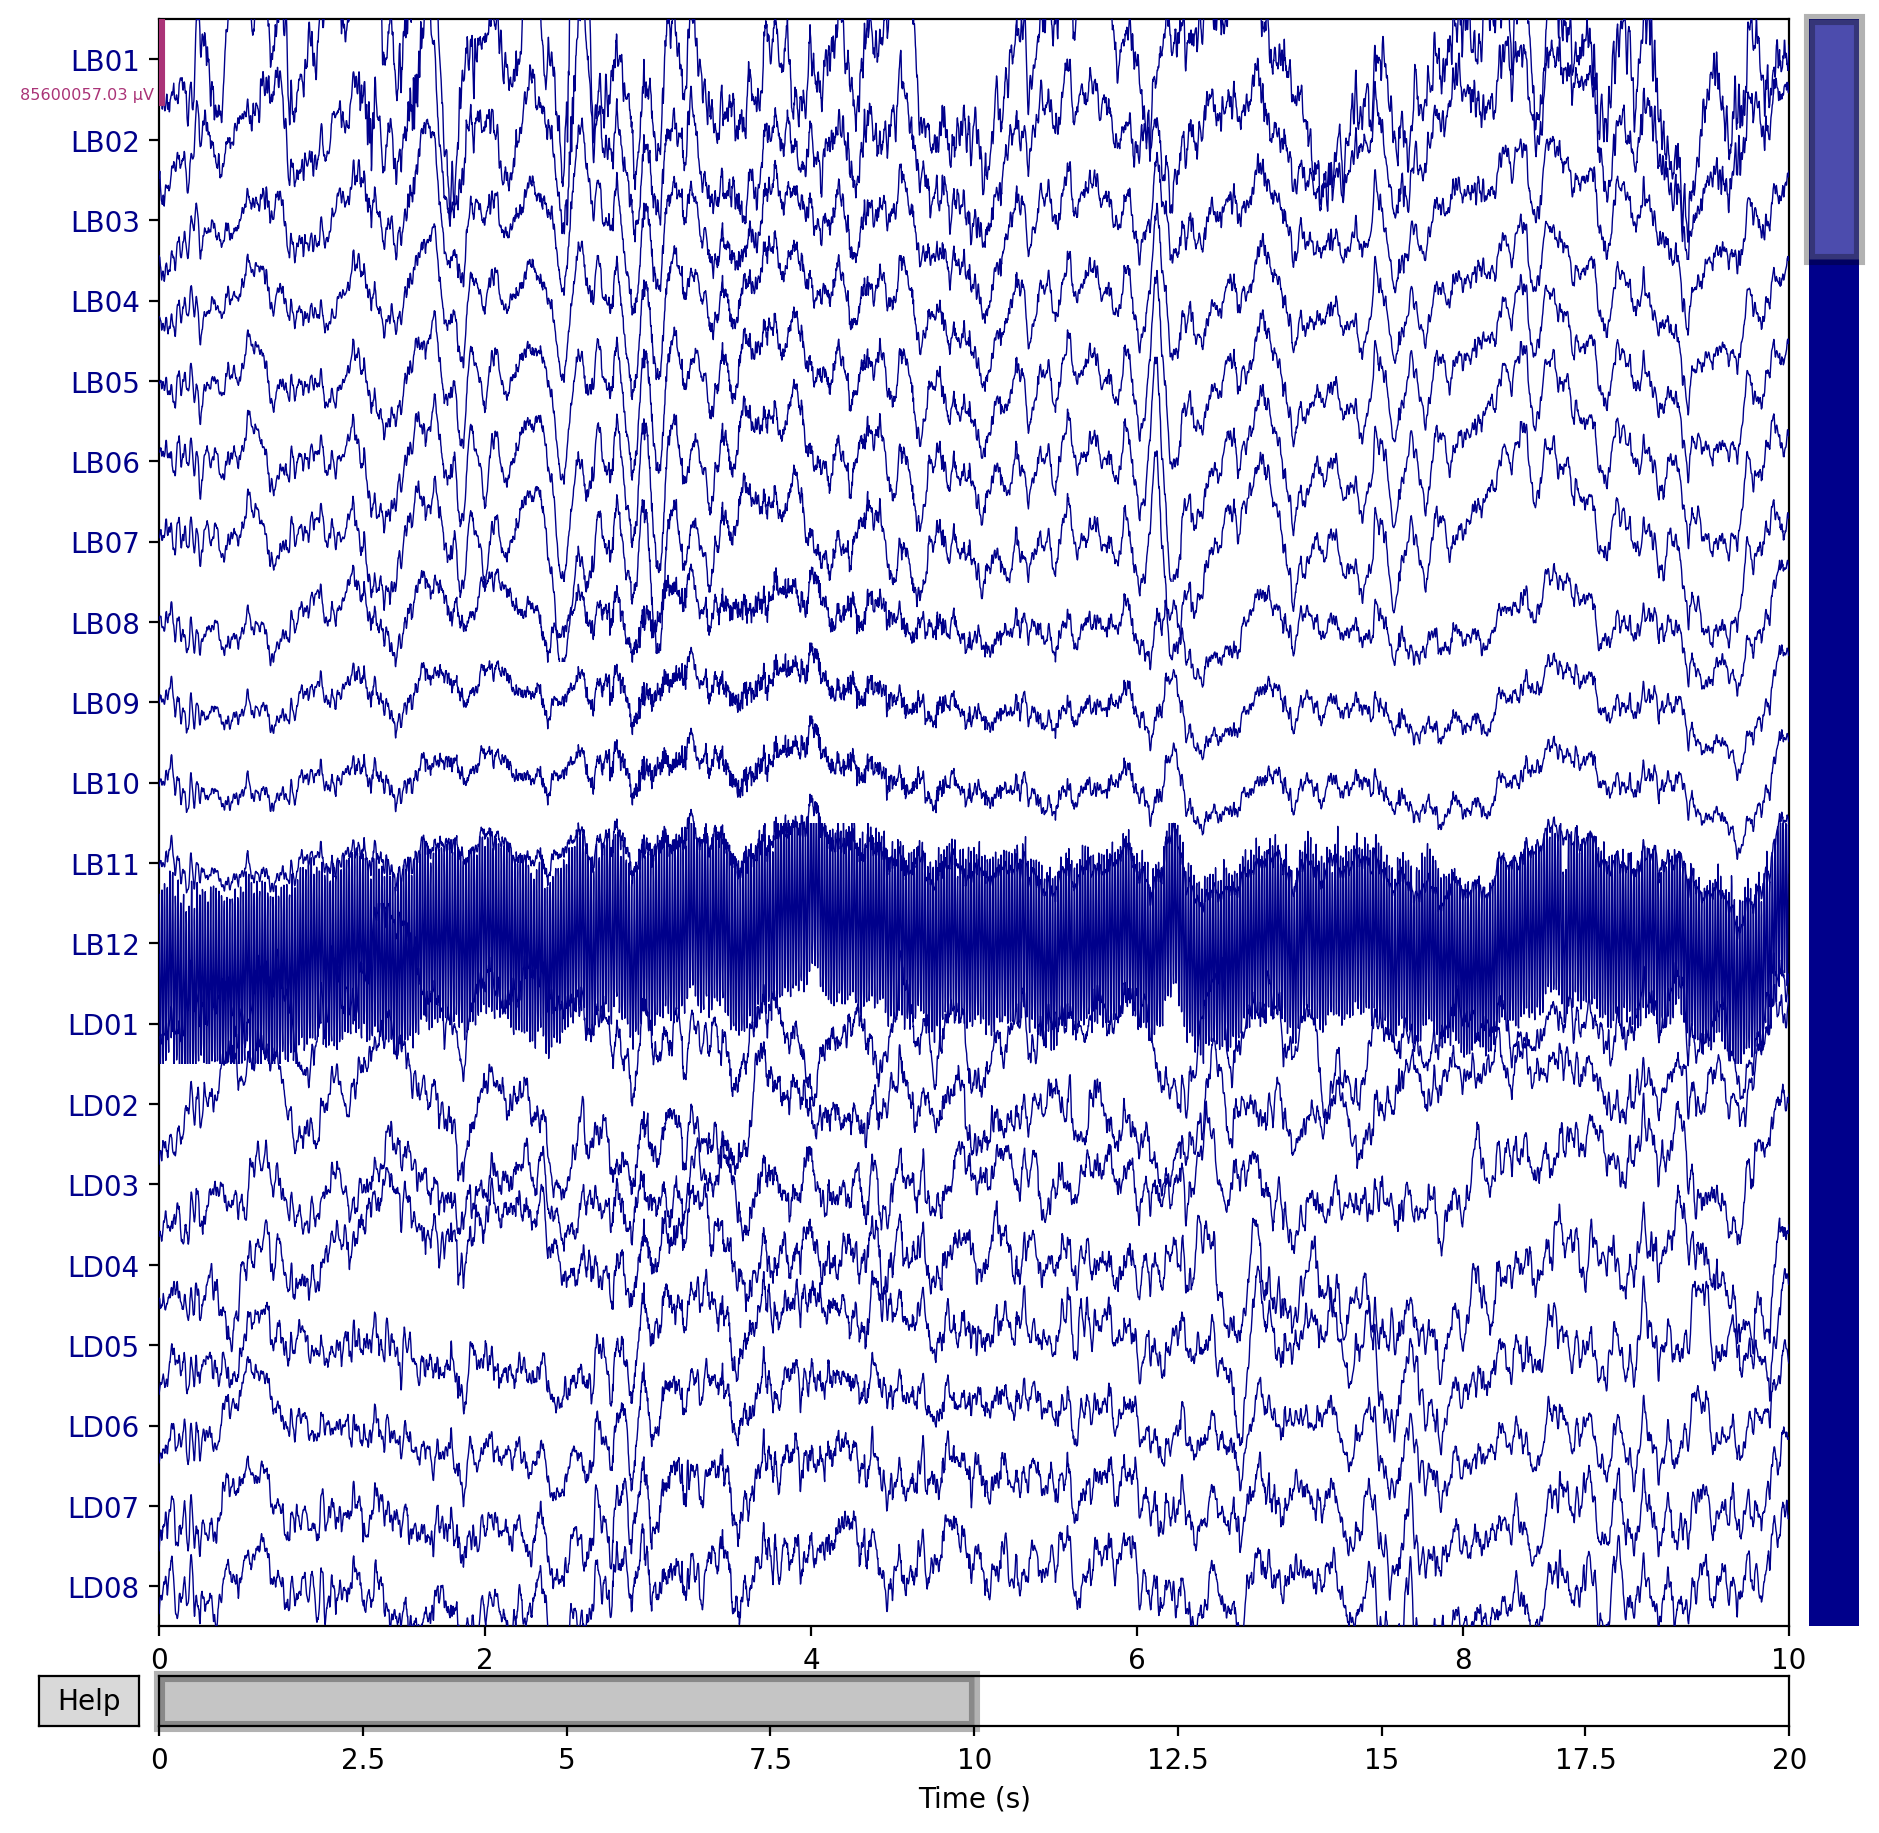

Channels marked as bad:
['LB12', 'RE08', 'RE09', 'RE10']


In [39]:
raw.plot(scalings = 'auto', color = 'darkblue')

Effective window size : 0.500 (s)


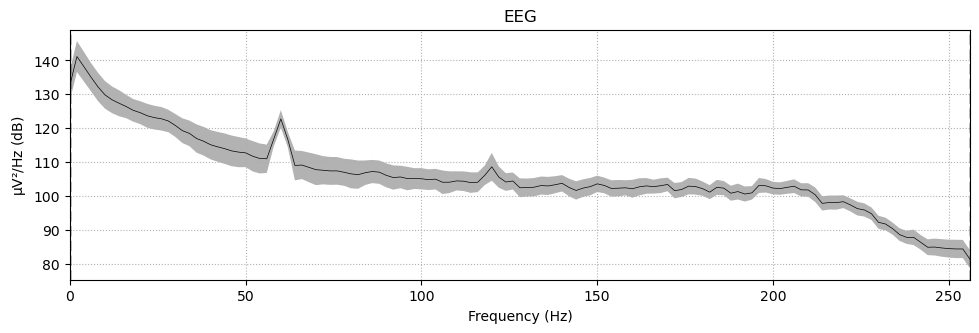

In [40]:
spectrum = raw.compute_psd()
spectrum.plot(average=True)

### HPF; ICA

In [41]:
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
ica = ICA(n_components=10, random_state = 97)
ica.fit(filt_raw)
ica

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Fitting ICA to data using 130 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.0s finished


Selecting by number: 10 components
Fitting ICA took 8.5s.


/opt/anaconda3/envs/ieegpy-dev-clone/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Method,fastica
Fit,1000 iterations on raw data (10240 samples)
ICA components,10
Available PCA components,130
Channel types,eeg
ICA components marked for exclusion,—


In [42]:
ica.get_explained_variance_ratio(filt_raw)

{'eeg': 0.9860293626631479}

Creating RawArray with float64 data, n_channels=10, n_times=10240
    Range : 0 ... 10239 =      0.000 ...    19.998 secs
Ready.


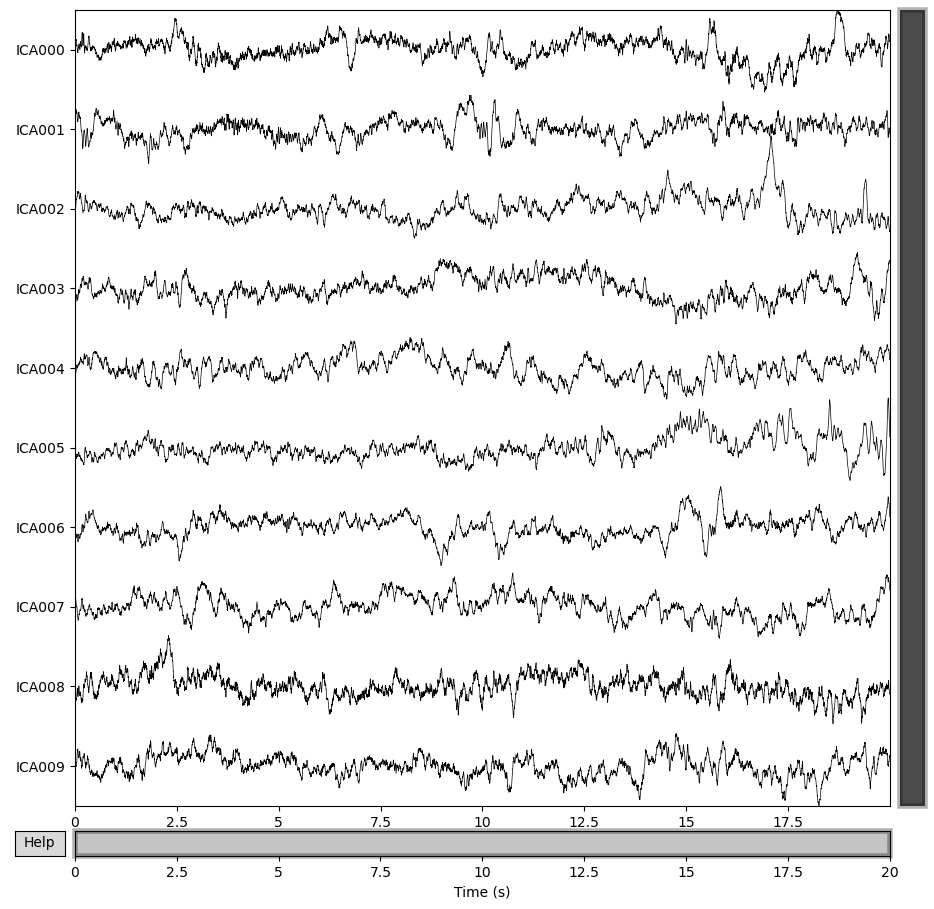

In [43]:
ica.plot_sources(raw)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 130 PCA components


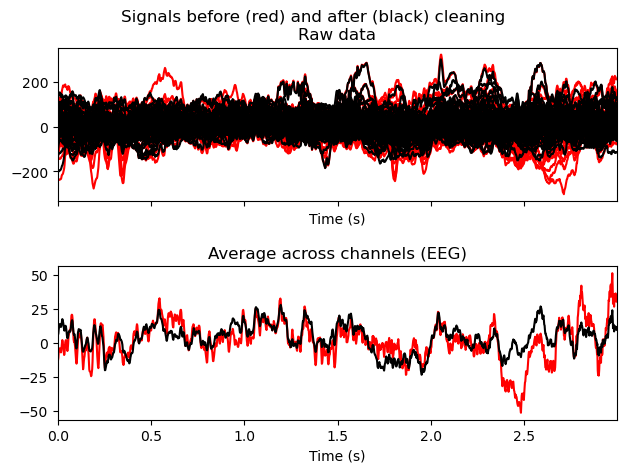

In [44]:
ica.plot_overlay(raw, exclude = [0, 1],
#  start = int(2e5), stop = int(3e5), 
 )

### Apply ICA exclusion

In [45]:
ica.exclude = [0, 1]  # indices chosen based on various plots above

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 130 PCA components


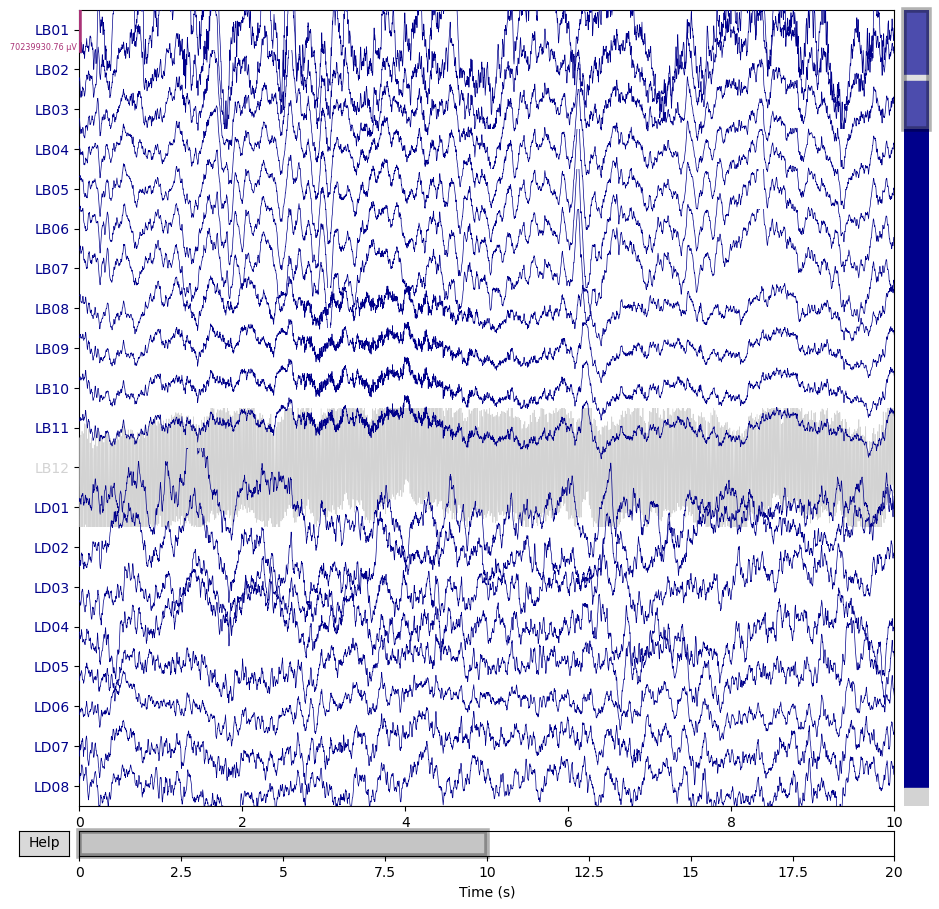

Channels marked as bad:
['LB12', 'RE08', 'RE09', 'RE10']


In [46]:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

reconst_raw.plot(scalings = 'auto', color = 'darkblue')

## Discussion Points
1. MNE-python is intuitive
    - built-in fns
    - needs eval for long term recording
        - likely better suited for CCEPs, multimodality data
2. ICA as an artifact reduction strategy
    - it works
    - manual oversight vs other clever strategies probably difficult for ieeg
    - again, likely more suitible for multimodal/epoch-type data